# 利用百度地图交通耗时制作交通等时圈
本notebook主要运用Arcpy结合百度地图交通耗时API，制作交通等时圈。
<成果图>

传统的交通等时圈分析是依据路网数据，通过网络分析工具，计算出各个点到中心点的最短路径，然后根据不同的时间，将各个点连接起来，形成等时圈。虽然这种方法可以得到较为精确的等时圈，但是需要有完整的路网数据，而且计算量也比较大。本文介绍一种利用百度地图交通耗时数据，制作交通等时圈的方法，该方法不需要路网数据，只需要百度地图的交通耗时数据，就可以制作出交通等时圈

## 0. 流程
1. 首先需要选择研究的区域，我们选用交互式地图`leafmap`库，在地图上画出**研究范围**与**起点**。
2. 将研究区域进行细分，细分成一个个网格，网格的大小根据研究区域的大小来确定，我们使用arcpy的`创建渔网工具`，同时生成只有每个渔网中心点的要素类，称之为`fishnet_label`，我们将使用`fishnet_label`的坐标进行后续操作，
3. 通过通过**百度地图API**的批量算路，获取交通耗时，获取各个`fishnet_label`的中心点到研究区域中心点的**交通耗时**，我们将耗时写入`fishnet_label`中。
4. 通过`反距离权重法`工具，制作出交通耗时等值线。
5. 最后，将交通耗时等值线与研究区域进行裁剪，并且进行进一步美化，导出为png，就可以得到交通等时圈图。

## 1. 准备工作
1. 安装相应库
    - 安装好ArcGIS Pro的arcpy
    -  
2. 申请百度地图API（网上资料很多，不详细说了）
    - 申请百度地图开放平台账号
    - 申请百度地图开放平台的开发者密钥



## 2.选定研究区域


我们引入leafmap库进行地图交互，在地图上画出研究范围。

In [1]:
import os
import random

import leafmap # pip install leafmap

In [2]:
# 实例化一个Map对象
m = leafmap.Map(center=[31.2338, 121.4684], # center代表初始地图中点；
                zoom=14,  # zoom表示缩放等级，数值越大地图比例就越大。
                draw_control=True, # draw_control表示显示绘图组件，可以不填，默认是True
) 

m

Map(center=[31.2338, 121.4684], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202309030043556.png)

平移和缩放地图以选择感兴趣的区域。使用绘图工具在地图上绘制多边形研究区域，然后在地图绘制点用来标记研究区域的起点，如果没绘制点则选取研究区域的中心点作为起点。

In [3]:
data = m.draw_control.data # 获取绘制的数据

points = [] # 用来存储点
polygon = None # 用来存储多边形

# 遍历绘制的数据
for i in data: 
    # 判断绘制的是点还是多边形
    if i['geometry']['type'] == 'Point':
        points.append(i['geometry']['coordinates']) # 获取点的坐标
        print("points", points)
    if i['geometry']['type'] == 'Polygon':
        polygon = i['geometry']['coordinates'][0] # 获取多边形的坐标
        print("polygon", polygon)
    else:
        print("PASS")
        

In [4]:
# 设置默认值
if not points:
    points = [[121.469511, 31.232326]]
    
if not polygon:
    polygon = [[121.456029, 31.22183], [121.456029, 31.241352], [121.482306, 31.241352], [121.482306, 31.22183], [121.456029, 31.22183]]

In [5]:
# # # 可以通过如下方法 获取用户绘制的多边形边框
# if m.user_roi_bounds() is not None:
#     bbox = m.user_roi_bounds()
#     print(bbox)
# else:
#     bbox = [121.4541, 31.22, 121.4853, 31.2425]

### 创建渔网
```
arcpy.management.CreateFishnet(out_feature_class, origin_coord, y_axis_coord, cell_width, cell_height, number_rows, number_columns, {corner_coord}, {labels}, {template}, {geometry_type})
```

In [6]:
# 导入arcpy
import arcpy

# 设置工作空间
home_dir = os.path.join(os.getcwd(), "resource", "交通等时圈")
# home_dir = r"."
# 创建一个文件地理数据库
if not arcpy.Exists(os.path.join(home_dir, "data.gdb")):
    arcpy.CreateFileGDB_management(home_dir, "data.gdb")

arcpy.env.workspace = os.path.join(home_dir, "data.gdb")

arcpy.env.overwriteOutput = True

# 设置空间参考对象
sr = arcpy.SpatialReference("WGS 1984") # 百度api可以直接使用WGS84坐标

In [7]:
# # 定义origin_coord和y_axis_coord
# 经度
x_min = polygon[0][0]
x_max = polygon[2][0]
# 纬度
y_min = polygon[0][1]
y_max = polygon[1][1]
x_min, y_min, x_max, y_max # 左下和右上的坐标

(121.456029, 31.22183, 121.482306, 31.241352)

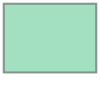

In [8]:
# 把points和polygon都转化为arcgis的几何对象
# 从array创建polygon
study_area = arcpy.Polygon(arcpy.Array([arcpy.Point(x_min, y_min), arcpy.Point(x_min, y_max), arcpy.Point(x_max, y_max), arcpy.Point(x_max, y_min)]), sr)

study_area

In [9]:
# 将其转换为要素类并复制到数据库
arcpy.management.CopyFeatures(study_area, "study_area")

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\Urban-Spatial-Data-Analysis-For-Beginners\\4-空间数据分析\\4.2-arcpy\\resource\\交通等时圈\\data.gdb\\study_area'>

![study_area](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308252237692.png)

In [10]:
# 设置输出坐标系
arcpy.env.outputCoordinateSystem = sr

In [17]:
# 偏移量
offset = 0.001
# extent用来指定渔网的范围
extent = " ".join([str(coord) for coord in [x_min - offset, y_min - offset, x_max + offset, y_max + offset]])
extent

'121.455029 31.22083 121.483306 31.242352'

In [18]:
out_fcs = "study_area_fishnet"
# 避免输出文件已存在
if arcpy.Exists(out_fcs):
    # 生成唯一的输出文件名
    unique_name = arcpy.CreateUniqueName(out_fcs)
    out_fcs = os.path.basename(unique_name) 
    print(f"输出要素类已存在，已经重命名为： {out_fcs}")

输出要素类已存在，已经重命名为： study_area_fishnet0


In [19]:
cell_width = cell_height = 0.001 # 0.001度约为100米

In [20]:
# 创建渔网 注意渔网的范围要比研究范围大一点，这样可以保证研究范围完全在渔网内
out_label = arcpy.management.CreateFishnet(out_feature_class = out_fcs, # 包含由矩形像元组成的渔网的输出要素类。
                               origin_coord = str(x_min-offset) + "  " + str(y_min-offset), # 矩形框的左下端点为原点
                               y_axis_coord = str(x_min-offset) + "  " + str(y_max-offset), # 此点与原点的连线用于判断旋转的角度 我们不用旋转所以定义为原点正上方的点
                               cell_width = cell_width, 
                               cell_height = cell_width,
                               number_rows = "", # 留空，由cell_width和cell_height决定
                               number_columns = "", # 留空，由cell_width和cell_height决定
                               corner_coord = None, # 对角坐标不填写
                               labels = "LABELS", # 输出标签 即输出渔网中心点的要素类
                               template = extent, # 以空格分隔的坐标字符串 - 将使用指定渔网的范围。坐标以 x-min，y-min，x-max，y-max 的顺序表示。
                               geometry_type = "POLYGON" # 生成面
                               )
out_label = out_fcs + "_label"
# 这里我是3.1.0版本，返回值有bug，本应该是带“_label”后缀的要素类，但是返回的是不带后缀的要素类，所以我手动加了后缀

In [28]:
# desc = arcpy.Describe(out_label)
# print(desc.name)
# for i in desc.fields:
#     print(i.name)

study_area_fishnet2_label
OID
Shape


详细讲讲这个函数的参数：

out_label为创建一个新的点要素类，其中每个渔网像元中心都是所在细分渔网的中心点，并且OID相等，方便我们对齐。最终我们生成了带有标注的渔网，如下图所示。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308252240699.png)

## 通过百度API获得最短交通耗时
数据来源： [百度批量算路服务](https://lbsyun.baidu.com/index.php?title=webapi/route-matrix-api-v2)
百度批量算路服务是一套以HTTP/HTTPS形式提供的轻量级批量算路接口，用户可通过该服务，根据起点和终点坐标计算路线规划距离和行驶时间。

**服务介绍**
- 批量算路目前支持驾车、摩托车、骑行（电动车/自行车）、步行。
- 根据起点和终点，批量计算路线的距离和耗时融入出行策略（不走高速、常规路线、距离较短），路线和耗时计算考虑实时路况。
- 驾车模式支持输入起点车头方向，提升准确性。
-  步行时任意起终点之间的距离不得超过200KM，超过此限制会返回参数错误
- 一次最多计算50条路线，起终点个数之积不能超过50。 比如2个起点25个终点，50个起点1个终点等
适用场景
适用于高并发场景，如网约车派单、物流配送派单场景，同时发起多个起终点之间的算路，筛选所需要的订单起终点

服务地址-驾车

```
https://api.map.baidu.com/routematrix/v2/driving?  //GET请求
```

服务地址-骑行

```
https://api.map.baidu.com/routematrix/v2/riding?  //GET请求
```

服务地址-步行

```
https://api.map.baidu.com/routematrix/v2/walking?  //GET请求
```

## 测试：构建url 参数介绍
需要传入url的参数有：百度ak，交通方式，起点坐标，终点坐标
补充参数：
**coord_type** 坐标类型 str：
 ，可选值为：bd09ll（百度经纬度坐标，默认）、bd09mc（百度墨卡托坐标）、gcj02（国测局加密坐标）、wgs84（gps设备获取的坐标）。本次选择wgs84

**tactics** str ：
默认为13：最短距离（不考虑路况）

驾车、摩托车可设置，其他无需设置。该服务为满足性能需求，不含道路阻断信息干预。

驾车偏好选择，可选值如下：
10： 不走高速；
11：常规路线，即多数用户常走的一条经验路线，满足大多数场景需求，是较推荐的一个策略
12： 距离较短（考虑路况）：即距离相对较短的一条路线，但并不一定是一条优质路线。计算耗时时，考虑路况对耗时的影响；
13： 距离较短（不考虑路况）：路线同以上，但计算耗时时，不考虑路况对耗时的影响，可理解为在路况完全通畅时预计耗时。 
注：除13外，其他偏好的耗时计算都考虑实时路况

摩托车偏好选择，可选值如下：
10： 不走高速；
11： 最短时间；
12： 距离较短。


以下代码为过程，可帮助理解，你也可以直接跳到后续完整代码。

In [ ]:
from dotenv import load_dotenv
import requests
import os

# 你可以注释掉这两行直接定义baidu_ak变量直接在此填写
load_dotenv(".env") # 读取环境变量文件
ak = os.getenv("baidu_ak") # 读取百度api 

trans_type = 'walking'

origins = str(y_min) + "," + str(x_min) # 纬度,经度 示例：40.056878,116.30815|40.063597,116.364973
des =  str(points[0][1]) + "," +  str(points[0][0]) 

print(origins)
print(des)

url = f'https://api.map.baidu.com/routematrix/v2/{trans_type}?output=json&origins={origins}&destinations={des}&tactics=11&coord_type=wgs84&ak={ak}'
# print(url)

用浏览器打开url，查看返回的数据:
{"status":0,"result":[{"distance":{"text":"2.2公里","value":2218},"duration":{"text":"32分钟","value":1897}}],"message":"成功"}

### 查询out_label的坐标 
url中目前我们需要将origins作为变量填入url 也就是out_label的坐标
通过查询游标来实现

In [265]:
# 通过查询游标，获取每个渔网的中心点坐标
# 因为我们构建的url传入的是origins和destinations字符串，所以我们需要将坐标点转换成字符串
data_dict = {}

with arcpy.da.SearchCursor(out_label, ["OID","SHAPE@XY"]) as cursor:
    for row in cursor:
        oid = row[0]
        origins = str(row[1][1]) + "," + str(row[1][0]) # 纬度,经度
        
        data_dict[oid] = origins

print(len(data_dict))
# 打印存储的数据
for oid, origins in data_dict.items():
    print(f"OID: {oid}, 坐标: {origins}")

588
OID: 1, 坐标: 31.22133000000005,121.45552900000007
OID: 2, 坐标: 31.22133000000005,121.45652900000005
OID: 3, 坐标: 31.22133000000005,121.45752900000002
OID: 4, 坐标: 31.22133000000005,121.45852900000006
OID: 5, 坐标: 31.22133000000005,121.45952900000009
OID: 6, 坐标: 31.22133000000005,121.46052900000007
OID: 7, 坐标: 31.22133000000005,121.46152900000004
OID: 8, 坐标: 31.22133000000005,121.46252900000002
OID: 9, 坐标: 31.22133000000005,121.46352900000005
OID: 10, 坐标: 31.22133000000005,121.46452900000008
OID: 11, 坐标: 31.22133000000005,121.46552900000006
OID: 12, 坐标: 31.22133000000005,121.46652900000004
OID: 13, 坐标: 31.22133000000005,121.46752900000007
OID: 14, 坐标: 31.22133000000005,121.4685290000001
OID: 15, 坐标: 31.22133000000005,121.46952900000008
OID: 16, 坐标: 31.22133000000005,121.47052900000006
OID: 17, 坐标: 31.22133000000005,121.47152900000003
OID: 18, 坐标: 31.22133000000005,121.47252900000007
OID: 19, 坐标: 31.22133000000005,121.4735290000001
OID: 20, 坐标: 31.22133000000005,121.47452900000008
OID: 21

OID: 162, 坐标: 31.22633000000005,121.47652900000003
OID: 163, 坐标: 31.22633000000005,121.47752900000006
OID: 164, 坐标: 31.22633000000005,121.4785290000001
OID: 165, 坐标: 31.22633000000005,121.47952900000007
OID: 166, 坐标: 31.22633000000005,121.48052900000005
OID: 167, 坐标: 31.22633000000005,121.48152900000002
OID: 168, 坐标: 31.22633000000005,121.48252900000006
OID: 169, 坐标: 31.22733000000005,121.45552900000007
OID: 170, 坐标: 31.22733000000005,121.45652900000005
OID: 171, 坐标: 31.22733000000005,121.45752900000002
OID: 172, 坐标: 31.22733000000005,121.45852900000006
OID: 173, 坐标: 31.22733000000005,121.45952900000009
OID: 174, 坐标: 31.22733000000005,121.46052900000007
OID: 175, 坐标: 31.22733000000005,121.46152900000004
OID: 176, 坐标: 31.22733000000005,121.46252900000002
OID: 177, 坐标: 31.22733000000005,121.46352900000005
OID: 178, 坐标: 31.22733000000005,121.46452900000008
OID: 179, 坐标: 31.22733000000005,121.46552900000006
OID: 180, 坐标: 31.22733000000005,121.46652900000004
OID: 181, 坐标: 31.22733000000005,

OID: 321, 坐标: 31.23233000000005,121.46752900000007
OID: 322, 坐标: 31.232330000000047,121.4685290000001
OID: 323, 坐标: 31.232330000000047,121.46952900000008
OID: 324, 坐标: 31.232330000000047,121.47052900000006
OID: 325, 坐标: 31.232330000000047,121.47152900000003
OID: 326, 坐标: 31.23233000000005,121.47252900000007
OID: 327, 坐标: 31.232330000000047,121.4735290000001
OID: 328, 坐标: 31.232330000000047,121.47452900000008
OID: 329, 坐标: 31.232330000000047,121.47552900000005
OID: 330, 坐标: 31.232330000000047,121.47652900000003
OID: 331, 坐标: 31.23233000000005,121.47752900000006
OID: 332, 坐标: 31.232330000000047,121.4785290000001
OID: 333, 坐标: 31.232330000000047,121.47952900000007
OID: 334, 坐标: 31.232330000000047,121.48052900000005
OID: 335, 坐标: 31.232330000000047,121.48152900000002
OID: 336, 坐标: 31.23233000000005,121.48252900000006
OID: 337, 坐标: 31.233330000000052,121.45552900000007
OID: 338, 坐标: 31.233330000000052,121.45652900000005
OID: 339, 坐标: 31.233330000000052,121.45752900000002
OID: 340, 坐标: 31.23

OID: 479, 坐标: 31.238330000000047,121.45752900000002
OID: 480, 坐标: 31.238330000000047,121.45852900000006
OID: 481, 坐标: 31.238330000000047,121.45952900000009
OID: 482, 坐标: 31.238330000000047,121.46052900000007
OID: 483, 坐标: 31.238330000000047,121.46152900000004
OID: 484, 坐标: 31.238330000000047,121.46252900000002
OID: 485, 坐标: 31.238330000000047,121.46352900000005
OID: 486, 坐标: 31.238330000000047,121.46452900000008
OID: 487, 坐标: 31.238330000000047,121.46552900000006
OID: 488, 坐标: 31.238330000000047,121.46652900000004
OID: 489, 坐标: 31.238330000000047,121.46752900000007
OID: 490, 坐标: 31.238330000000047,121.4685290000001
OID: 491, 坐标: 31.238330000000047,121.46952900000008
OID: 492, 坐标: 31.238330000000047,121.47052900000006
OID: 493, 坐标: 31.238330000000047,121.47152900000003
OID: 494, 坐标: 31.238330000000047,121.47252900000007
OID: 495, 坐标: 31.238330000000047,121.4735290000001
OID: 496, 坐标: 31.238330000000047,121.47452900000008
OID: 497, 坐标: 31.238330000000047,121.47552900000005
OID: 498, 坐标: 

### 解析返回的数据

In [251]:
# 发送请求并解析返回的json数据
import json
r = requests.get(url)
if r.status_code == 200:
    content = r.text
    item = json.loads(content) # 用son.loads()将json格式的字符串转换成python中的字典

    if item["status"] == 0:
        # 提取duration中的value值
        duration_min = item['result'][0]['duration']['value'] / 60 # 转换成分钟
    else:
        print(item["status"])

else:
    print(r.status_code)
    exit()

In [252]:
duration_min

32.766666666666666

### 遍历中心点坐标

In [263]:
for oid, origins in data_dict.items():
    url = f'https://api.map.baidu.com/routematrix/v2/{trans_type}?output=json&origins={origins}&destinations={des}&tactics=11&coord_type=wgs84&ak={ak}'
#     print(url)

In [264]:
# 可以将url和oid储存起来
# 构建url字典
for oid, origins in data_dict.items():
    base_url = f'https://api.map.baidu.com/routematrix/v2/{trans_type}?'
    url = base_url + f'output=json&origins={origins}&destinations={des}&tactics=11&coord_type=wgs84&ak={ak}'
    data_dict[oid] = url
print(len(data_dict))

588


In [ ]:
一共有588个坐标和之前一样

### 接下来我们需要将请求的数据填入到渔网中

In [102]:
# 首先需要创建一个字段# 首先需要创建一个字段
if not arcpy.ListFields(out_label, "time"):
    arcpy.management.AddField(out_label, "time", "DOUBLE") # 添加一个叫time的字段，类型为double

In [47]:
def update_row(fcs, oid, duration_min):
    """更新游标，将duration_min填入time字段"""
    field_names = ["OID","SHAPE@XY", "time"] # 定义字段名称
    where_clause= f"OID = {oid}"
    
    with arcpy.da.UpdateCursor(fcs, field_names, where_clause) as cursor:
        for row in cursor:
            row[2] = duration_min # 将时间填入time字段
            cursor.updateRow(row)
            print(row[0],row[1],row[2])

oid = 1
update_row(out_label, oid, duration_min)

1 (121.45360000000005, 31.219500000000043) 31.4


可以在arcgis中看到，我们已经将时间填入到了time字段中。
![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308261148437.png)

### 控制并发数

由于百度API有并发数限制，所以我们需要控制并发数，这里我们使用线程池来控制并发数。
还有批量算路服务的配额和并发是按最终路线数来计算，而非RouteMatrix API请求数。如一次请求2个起点5个终点，则最终路线输出为2*5=10条，配额计为10次。

![](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308252243059.png)



我们使用使用 [asyncio](https://docs.python.org/zh-cn/3.11/library/asyncio.html) 进行异步请求，同时结合[aiohttp](https://docs.aiohttp.org/en/stable/)等异步库实现每秒最多30次的请求。
简单介绍一下：
asyncio 是用来编写 并发 代码的库，使用 async/await 语法。
当尝试异步请求多个 URL：

```python
import asyncio
import aiohttp

async def fetch(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.text()  # await 表达式用于获得协程执行的结果

async def main():
    urls = [
        'https://example.com',
        'https://google.com',
        'https://github.com'
    ]
    tasks = [fetch(url) for url in urls]
    results = await asyncio.gather(*tasks)
    for url, result in zip(urls, results):
        print(f"URL: {url}\nContent: {result}\n")

asyncio.run(main())
```

在这个示例中，我们定义了一个 `fetch()` 函数，它使用 `aiohttp` 库发送异步 GET 请求并返回响应的文本内容。然后，在 `main()` 函数中，我们创建了一个 URL 列表，并为每个 URL 创建了一个 `fetch()` 任务。使用 `asyncio.gather()` 函数来并发运行这些任务，并等待它们完成。最后，我们将每个 URL 和对应的响应内容打印出来。

### 在jupyter notebook中使用asyncio需要注意的问题
[在jupyter notebook中使用asyncio.run()时asyncio.run() cannot be called from a running event loop问题解决
](https://stackoverflow.com/questions/55409641/asyncio-run-cannot-be-called-from-a-running-event-loop-when-using-jupyter-no)
jupyter（IPython ≥ 7.0）已经在运行一个事件循环：
因此，您不需要自己启动事件循环，而是可以直接调用 await main(url) ，即使您的代码位于任何异步函数之外。

In jupyter

```python
async def main():
    	print(1)
await main()
```

In plain Python (≥3.7)

```python
import asyncio
async def main():
    print(1)
asyncio.run(main())
```

如果你想同时在notebook和脚本中运行，可以使用以下代码：
如果有人想检测一个循环是否正在运行并自动调整（即在现有循环上运行 main() ，否则运行 asyncio.run() ），这里有一个片段可能会证明是有用的：
```python
# async def main():
#     ...

try:
    loop = asyncio.get_running_loop()
except RuntimeError:  # 'RuntimeError: There is no current event loop...'
    loop = None

if loop and loop.is_running():
    print('Async event loop already running. Adding coroutine to the event loop.')
    tsk = loop.create_task(main())
    # ^-- https://docs.python.org/3/library/asyncio-task.html#task-object
    # Optionally, a callback function can be executed when the coroutine completes
    tsk.add_done_callback(
        lambda t: print(f'Task done with result={t.result()}  << return val of main()'))
else:
    print('Starting new event loop')
    result = asyncio.run(main())
```


与此同时我们还要解决每秒最多30次的请求的问题，我们使用asyncio、asyncio.Semaphore和计数器来控制每秒最多请求30次。
1. asyncio负责异步请求：保证发起网络请求之后，不会阻塞主线程。即等待进程网络请求的过程中，主线程可以继续进行time字段的更新。
2. asyncio.Semaphore负责控制并发数，保证可以进行30次并发请求，超过30次的请求会被阻塞。保证速度
3. ~~计数器负责计算每秒的请求数，每秒重置一次计数器，保证每秒最多30次的请求。保证满足api的限制。~~  为了图方便，我们可以使用asyncio.sleep()在达到30次请求之后，等待1秒钟，然后再继续请求。

我用一个示例演示一下：

In [61]:
import asyncio
import aiohttp

async def fetch(url):
    """发送请求并返回response的信息，此处演示返回status状态码"""
    async with aiohttp.ClientSession() as session: # 创建一个session
        async with session.get(url) as response: # 发送请求
            return response.status  # 返回status状态码

async def limited_fetch(url, semaphore):
    """限制并发数"""
    async with semaphore: # 限制并发数 with语句相当于获取进程锁 执行完再释放进程锁
        # 进程中的代码
        result = await fetch(url) # 异步获取请求的结果
        await asyncio.sleep(10) # 超过semaphore定义的进程数则等待 此处图简单没有用到更精确的计数器
        return result # 返回请求的结果 在后续处理

async def main():
    """执行的主程序"""
    urls = ["https://www.baidu.com/" for _ in range(1, 100)] # 测试
    print(len(urls))
    semaphore = asyncio.Semaphore(30)  # 最多并发30次

    tasks = [] # 用来存储任务

    # 负责发起请求并处理结果
    async def request_task(url, count):
        """负责发起请求并处理结果"""
        # 每个请求都会通过limited_fetch()函数进行限制，以确保不超过并发限制。
        result = await limited_fetch(url, semaphore)

        # 接下来处理结果
        print(count, result)

    count = 0 # 测试用 计数器
    for url in urls:
        count += 1
        task = asyncio.create_task(request_task(url, count))
        tasks.append(task)

    await asyncio.gather(*tasks)

# loop = asyncio.get_event_loop()
# loop.run_until_complete(main())
await main() # 执行主程序

99
1 200
3 200
2 200
5 200
10 200
13 200
9 200
6 200
8 200
11 200
7 200
4 200
16 200
20 200
14 200
18 200
24 200
30 200
27 200
26 200
28 200
15 200
25 200
23 200
29 200
22 200
19 200
12 200
21 200
17 200
34 200
41 200
46 200
47 200
48 200
44 200
40 200
49 200
52 200
59 200
33 200
35 200
42 200
50 200
37 200
31 200
36 200
32 200
45 200
53 200
57 200
51 200
55 200
54 200
60 200
43 200
56 200
38 200
39 200
58 200
65 200
64 200
72 200
63 200
68 200
71 200
73 200
62 200
81 200
75 200
83 200
77 200
66 200
90 200
79 200
69 200
84 200
74 200
82 200
80 200
61 200
89 200
70 200
67 200
78 200
87 200
85 200
88 200
86 200
76 200
91 200
95 200
96 200
92 200
97 200
93 200
98 200
99 200
94 200


### 成功运行之后我们来根据上面的框架来构建我们的程序
以下代码为完整代码

#### 首先需要获取含有渔网oid和url的字典

In [36]:
from dotenv import load_dotenv
import os

def search_row(out_feature_class):
    """查询渔网的各中心点，返回字典"""
    data_dict = {}
    
    with arcpy.da.SearchCursor(out_feature_class, ["OID","SHAPE@XY"]) as cursor:
        for row in cursor:
            oid = row[0]
            origins = str(row[1][1]) + "," + str(row[1][0]) # 纬度,经度

            data_dict[oid] = origins
    print("查询完成，共有{}个点".format(len(data_dict)))
    
    return data_dict

def create_url(trans_type, out_feature_class, ak):
    """根据渔网返回百度批量算路的url字典"""
    
    # 固定url参数
    
    base_url = f"https://api.map.baidu.com/routematrix/v2/{trans_type}?"
    
    des = str((y_min + y_max) / 2) + "," +  str(round((x_min + x_max) / 2, 4)) # 中心点
    
    # 获取渔网中心点的字典
    data_dict = search_row(out_feature_class) 
    
    # 构建url字典
    item = {}
    for oid, origins in data_dict.items():
        if trans_type != "walking":
            url = base_url + f'output=json&origins={origins}&destinations={des}&tactics=11&coord_type=wgs84&ak={ak}'
        else:
            tactics = "12" # 距离较短（考虑路况）：即距离相对较短的一条路线，但并不一定是一条优质路线。计算耗时时，考虑路况对耗时的影响
            url = base_url + f'output=json&origins={origins}&destinations={des}&tactics=11&coord_type=wgs84&ak={ak}&tactics={tactics}'
        
        item[oid] = url
        
    return item


# !!!此处要修改 你可以注释掉这两行直接定义baidu_ak变量直接在此填写
# load_dotenv(r"C:\Users\hncdj\Documents\Python_\Python辅助城市研究\Urban-Spatial-Data-Analysis-For-Beginners\.env") # 读取环境变量文件 
# ak = os.getenv("baidu_ak") # 读取百度api 
# urls = create_url(trans_type = 'walking', out_feature_class=out_label, ak = ak)
# for oid, url in urls.items():
#     print(oid, url)

### 接下来我们请求数据 同时利用之前的更新游标来把数据写入到渔网中
这里我一并构建函数了：

In [37]:
import asyncio
import aiohttp
import json

async def perform_request(url):
    """发送请求 请求成功后 返回content"""
    async with aiohttp.ClientSession() as session: # 创建一个session
        async with session.get(url) as response: # 发送请求
            status = response.status
            if status == 200:
                content = await response.text()  # 使用await等待协程的执行结果
                return content
            else:
                print(f"请求失败，状态码为{status}")
                return None

async def limited_fetch(url, semaphore):
    """限制并发数"""
    async with semaphore: # 限制并发数 with语句相当于获取进程锁 执行完再释放进程锁
        # 进程中的代码
        result = await perform_request(url) # 异步获取请求的结果
        await asyncio.sleep(1) # 超过semaphore定义的进程数则等待 此处图简单没有用到更精确的计数器
        return result # 返回请求的结果 在后续处理


def get_time(content):
    """提取时间"""
    item = json.loads(content) # 用son.loads()将json格式的字符串转换成python中的字典
    if item["status"] == 0:
        # 提取duration中的value值
        duration_min = round(item['result'][0]['duration']['value'] / 60, 1) # 转换成分钟
        return duration_min
    else:
        print(content)
        return None
    
    
def update_row(out_feature_class, oid, duration_min):
    """更新游标，将duration_min填入time字段"""
    field_names = ["OID","SHAPE@XY", "time"] # 定义字段名称
    where_clause= f"OID = {oid}"
    
    with arcpy.da.UpdateCursor(out_feature_class, field_names, where_clause) as cursor:
        for row in cursor:
            row[2] = duration_min # 将时间填入time字段
            cursor.updateRow(row)
            # print(f"成功更新{oid}：{duration_min}分钟")
            

async def main():
    """执行的主程序"""
    # 修改如下变量
    fcs = out_label
    ws = arcpy.env.workspace
    trans_type = 'walking'
    
    # !!!此处要修改 你可以注释掉这两行直接定义baidu_ak变量直接在此填写
    load_dotenv(r"C:\Users\hncdj\Documents\Python_\Python辅助城市研究\Urban-Spatial-Data-Analysis-For-Beginners\.env") # 读取环境变量文件 
    ak = os.getenv("baidu_ak") # 读取百度api 
    
    urls = create_url(trans_type, fcs, ak)
    
    if not arcpy.ListFields(fcs, "time"):
        arcpy.management.AddField(fcs, "time", "DOUBLE") # 添加一个叫time的字段，类型为double
        
    semaphore = asyncio.Semaphore(30)  # 最多并发30次

    tasks = [] # 用来存储任务
    
    async def request_task(oid, url, out_feature_class):
        """负责发起请求并处理结果，更新游标"""
        # 每个请求都会通过limited_fetch()函数进行限制，以确保不超过并发限制。
        result = await limited_fetch(url, semaphore)
        
        # 执行处理函数
        duration_min = get_time(result)
        update_row(fcs, oid, duration_min)
    
    with arcpy.da.Editor(ws) as edit: #对工作空间开启编辑，防止锁占用
        for oid, url in urls.items(), desc="Processing":
            task = asyncio.create_task(request_task(oid, url, fcs))
            tasks.append(task)

    await asyncio.gather(*tasks)

# loop = asyncio.get_event_loop()
# loop.run_until_complete(main())
await main() # 执行主程序

查询完成，共有638个点


CancelledError: 

In [ ]:
代码说明：


## 制作交通耗时等值线
### 反距离权重法`arcpy.sa.Idw()`工具

In [25]:
Idw_raster = arcpy.sa.Idw(
    in_point_features=out_label,
    z_field="time",
    cell_size=7.99999999999272E-05,
    power=2,
    search_radius="VARIABLE 12",
    in_barrier_polyline_features=None
)
# Idw_raster.save("Idw_raster")


### 裁剪栅格
裁剪到研究范围

In [26]:
arcpy.management.Clip(
    in_raster=Idw_raster,
    rectangle=study_area,
    out_raster="Idw_raster_clip",
    in_template_dataset="study_area",
    nodata_value="3.4e+38",
    clipping_geometry="NONE",
    maintain_clipping_extent="NO_MAINTAIN_EXTENT"
)

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\Urban-Spatial-Data-Analysis-For-Beginners\\4-空间数据分析\\4.2-arcpy\\resource\\交通等时圈\\data.gdb\\Idw_raster_clip'>

In [ ]:
### 重分类进行分级
# TODO

In [30]:
# （可选）保存为tif
arcpy.management.CopyRaster(
    in_raster="Idw_raster_clip",
    out_rasterdataset=os.path.join(home_dir, "Idw_raster_clip.tif"),
    format="TIFF",
)

<Result 'C:\\Users\\hncdj\\Documents\\Python_\\Python辅助城市研究\\Urban-Spatial-Data-Analysis-For-Beginners\\4-空间数据分析\\4.2-arcpy\\resource\\交通等时圈\\Idw_raster_clip.tif'>

## 出图
这一步最好在软件中操作，比较麻烦，也因人而异。可以结合叠加交通、兴趣点，自己的项目来出图。比如:

![xx项目步行等时圈
](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308270025455.png)

![xx项目骑行等时圈](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202308270027164.png)



In [38]:
m.add_raster(os.path.join(home_dir, "Idw_raster_clip.tif"), layer_name="交通等时圈") # pip install localtileserver

m

ImportError: localtileserver is not installed. Please install it before proceeding. https://github.com/banesullivan/localtileserver